In [1]:
from azureml.core import Run, Experiment, Workspace

In [2]:
ws = Workspace.get("{workspace-name}", subscription_id="{subscription-id}")

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [ ]:
ws.get_details()

In [ ]:
ws.experiments

In [5]:
experiment = Experiment(ws, "amls-learn-experimentnew5")

In [6]:
run = Run(experiment, run_id="amls-learn-experimentnew5_1573401953_4a1fd5d9")

In [19]:
model = run.register_model(model_name='sklearn_mnist_model.pkl',
                           model_path='outputs/sklearn_mnist_model.pkl',
                           tags = {'area': "MNIST", 'type': "sklearn"},
                           description = "identify numbers")

print(model.name, model.id, model.version, sep='\t')

sklearn_mnist_model.pkl	sklearn_mnist_model.pkl:1	1


In [20]:
%%writefile score.py
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import numpy
import json

def init():
    global model
    model_path = Model.get_model_path('sklearn_mnist_model.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = numpy.array(data)
        result = model.predict(data)
        # you can return any datatype if it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


In [21]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

print('Done')

Done


In [22]:
# register model
model = run.register_model(model_name='sklearn_mnist_model.pkl',
                           model_path='outputs/sklearn_mnist_model.pkl')

print(model.name, model.id, model.version, sep='\t')

sklearn_mnist_model.pkl	sklearn_mnist_model.pkl:2	2


In [7]:
from azureml.core.image import Image, ContainerImage

In [8]:
image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="myenv.yml",
                                 tags = {'data': "MNIST", 'type': "sklearn"},
                                 description = "Image for sklearn model")

In [23]:
image = Image.create(name = "myimage1",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

print('Done')

Creating image
Running................................
Succeeded
Image creation operation finished for image myimage1:1, operation "Succeeded"
Done


In [21]:
image = Image.list(ws)[0]

In [10]:
from azureml.core.webservice import AciWebservice

In [11]:
aciconfig = AciWebservice.deploy_configuration(cpu_cores =1, 
                                               memory_gb=1, 
                                               tags={"data": "mnist", "type": "sklearn"},
                                              description="Handwriting recognition")

print('Done')

Done


In [13]:
from azureml.core.webservice import Webservice

In [14]:
service_name = 'aci-mnist-1'

In [23]:
service = Webservice.deploy_from_image(deployment_config= aciconfig,
                                      image=image,
                                      name= service_name,
                                      workspace = ws)

In [24]:
service.wait_for_deployment(show_output = True)

print('Done')

Running...........
Succeeded
ACI service creation operation finished, operation "Succeeded"
Done


In [26]:
import os
import urllib.request

#create a folder for the dataset
os.makedirs('./data', exist_ok = True)

# load dataset to the directory--as you can see, you must load train sets and test sets separately
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x2086419de48>)

In [27]:
import os 

import gzip
import struct
import numpy as np


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

data_folder = os.path.join(os.getcwd(), 'data')

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(
    data_folder, 'test-labels.gz'), True).reshape(-1)

print('Done')

Done


In [31]:
# To help the model converge faster, shrink the intensity values (X) from 0-255 to 0-1

X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

print('Data loaded')

Data loaded


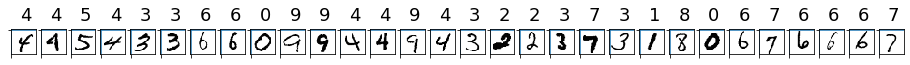

Done


In [32]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np


count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
    
plt.show()

print('Done')

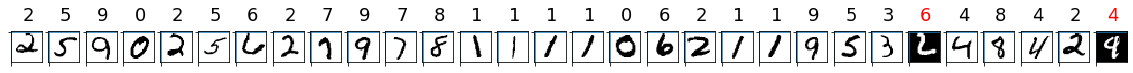

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))
#plt.figure(figsize=(9, 3))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)

    i = i + 1

plt.show()

In [29]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to include the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://934b545e-439f-41e9-b472-ed7a23a7c075.uksouth.azurecontainer.io/score
label: 9
prediction: [9]


In [4]:
# Load the diabetes dataset, a well-known built-in small dataset that comes with scikit-learn.
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('Done')

Done


In [6]:
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
import logging

automl_config = AutoMLConfig(task = 'regression',
                  iteration_timeout_minutes = 10,
                  iterations = 3,
                  primary_metric = 'spearman_correlation',
                  n_cross_validations = 5,
                  debug_log = 'automl.log',
                  verbosity = logging.INFO,
                  X = X_train, 
                  y = y_train)

print('Done')

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


Done


In [7]:
from azureml.core.experiment import Experiment

experiment = Experiment(workspace = ws, name = "my-third-experiment")

print('Done')

Done


In [8]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_285cbf80-bdbf-43c8-9adf-1f8df82e0127
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:00:11       0.6934    0.6934
         1   MinMaxScaler RandomForest                      0:00:12       0.6794    0.6934
         2   StandardScalerWrapper ExtremeRandomTrees   

In [56]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [10]:
best_run, fitted_model = local_run.get_output()

In [17]:
type(list(local_run.get_output())[0])

azureml.core.run.Run

In [18]:
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train
y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
y_test

array([321., 215., 127.,  64., 175., 275., 179., 232., 142.,  99., 252.,
       174., 129.,  74., 264.,  49.,  86.,  75., 101., 155., 170., 276.,
       110., 136.,  68., 128., 103.,  93., 191., 196., 217., 181., 168.,
       200., 219., 281., 151., 257.,  49., 198.,  96., 179.,  95., 198.,
       244.,  89., 214., 182.,  84., 270., 156., 138., 113., 131., 195.,
       171., 122.,  61., 230., 235.,  52., 121., 144., 107., 132., 302.,
        53., 317., 137.,  57.,  98., 170.,  88.,  90.,  67., 163., 104.,
       186., 180., 283., 141., 150.,  47., 297., 104.,  49., 103., 142.,
        59.])

In [36]:
y_pred_test

array([268.14588983, 222.32547443, 163.03726784, 118.20378222,
       192.04560999, 220.92582378, 105.85816365, 188.14198295,
       150.75946304, 226.92594223, 151.0951542 , 198.26015707,
       132.47541639,  99.8127997 , 251.95070004,  90.61048412,
       142.27851712,  75.45550277,  99.06952156, 231.52565508,
       170.00288879, 157.43197634, 137.43651515, 153.74604278,
       193.68635125, 167.72223924, 127.46171311,  93.6221311 ,
       150.40433622, 159.24776193, 185.89952673,  84.44149371,
       132.52236611, 170.79378797, 149.23160823, 191.92041513,
       163.11560085, 156.4553819 , 102.34169312, 198.09826503,
        93.58330999, 163.40194668, 141.78494156, 192.01714522,
       196.7383416 ,  84.65891547, 134.4869678 , 120.24669312,
       127.75158872, 219.24574563, 148.99563942,  84.29727029,
       161.97222222, 171.33504827, 213.87943674, 174.99748234,
       171.55388829, 111.20797709, 147.21253303, 167.96356043,
       200.30010811, 153.54747625, 163.06613343, 119.45

In [40]:
mean_squared_error(y_test, y_pred_test)

3246.160728489623

In [42]:
mean_absolute_error(y_test, y_pred_test)

45.61665651200832

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [47]:
model = GradientBoostingClassifier()

In [48]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [52]:
prediction = model.predict(X_test)

In [53]:
mean_absolute_error(prediction, y_test)

64.43820224719101

In [54]:
mean_squared_error(prediction, y_test)

6660.393258426966